In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
from glob import glob
import nibabel as nib
import pickle
from tqdm import tqdm
import random
from torchvision.transforms import transforms
from scipy import ndimage
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
nibabel.__version__

NameError: name 'nibabel' is not defined

In [2]:
!nvidia-smi

Fri Apr  8 14:08:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:5E:00.0 Off |                    0 |
| N/A   26C    P0    25W / 250W |      4MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:86:00.0 Off |                    0 |
| N/A   

In [2]:
train_imgs = '/home/sarucrcv/datasets/Task01_BrainTumour/imagesTr/'
train_labels = '/home/sarucrcv/datasets/Task01_BrainTumour/labelsTr/'

In [3]:
imgsList = os.listdir(train_imgs)
len(imgsList)

484

In [5]:
with open('train.txt','w') as f:
    
    f.write('\n'.join(imgsList[:400]))
    f.close()
    
with open('val.txt','w') as f:
    
    f.write('\n'.join(imgsList[400:]))

In [3]:

modalities = ('flair', 't1ce', 't1', 't2')

# train
train_set = {
        'tpath': '/home/sarucrcv/projects/3dunet/train_pkl_all/', #Target Path of pickle files
        'root': '/home/sarucrcv/datasets/Task01_BrainTumour/', 
        'flist': 'train.txt',
        'has_label': True
        }

# test/validation data
valid_set = {
        'tpath': '/home/sarucrcv/projects/3dunet/val_pkl_all/',
        'root': '/home/sarucrcv/datasets/Task01_BrainTumour/',
        'flist': 'val.txt',
        'has_label': True
        }


def nib_load(file_name):
    if not os.path.exists(file_name):
        print('Invalid file name, can not find the file!')

    proxy = nib.load(file_name)
    data = proxy.get_fdata()
    proxy.uncache()
    return data


def process_i16(path, has_label=True):
    """ Save the original 3D MRI images with dtype=int16.
        Noted that no normalization is used! """
    label = np.array(nib_load(path + 'seg.nii.gz'), dtype='uint8', order='C')

    images = np.stack([
        np.array(nib_load(path + modal + '.nii.gz'), dtype='int16', order='C')
        for modal in modalities], -1)# [240,240,155]

    output = path + 'data_i16.pkl'

    with open(output, 'wb') as f:
        print(output)
        print(images.shape, type(images), label.shape, type(label))  # (240,240,155,4) , (240,240,155)
        pickle.dump((images, label), f)

    if not has_label:
        return


def process_f32b0(tpath, img_path, label_path, has_label=True):
    """ Save the data with dtype=float32.
        z-score is used but keep the background with zero! """
    
    label = np.array(nib_load(label_path), dtype='uint8', order='C')
    images = np.stack(np.array(nib_load(img_path), dtype='float32', order='C'))  # [240,240,155]
    foldername = img_path.split('/')[-1]
    output = tpath + foldername + '_data_f32b0.pkl'
    mask = images.sum(-1) > 0
    for k in range(4):

        x = images[..., k]  #
        y = x[mask]

        # 0.8885
        x[mask] -= y.mean()
        x[mask] /= y.std()

        images[..., k] = x

    with open(output, 'wb') as f:
        print(output)

        if has_label:
            pickle.dump((images, label), f)
        else:
            pickle.dump(images, f)

    if not has_label:
        return


def doit(dset):
    root, has_label = dset['root'], dset['has_label']
    file_list = os.path.join(dset['flist'])
    names = open(file_list).read().splitlines()
    imgs_paths = [os.path.join(root, 'imagesTr', name) for name in names]
    labels_paths = [os.path.join(root, 'labelsTr', name) for name in names]

    for i in tqdm(range(len(imgs_paths))):
        process_f32b0(dset['tpath'],imgs_paths[i], labels_paths[i], has_label)


    # doit(test_set)


In [4]:
doit(train_set)

  0%|          | 0/400 [00:00<?, ?it/s]

/home/sarucrcv/projects/3dunet/train_pkl_all/BRATS_324.nii.gz_data_f32b0.pkl


  0%|          | 1/400 [00:01<13:15,  1.99s/it]

/home/sarucrcv/projects/3dunet/train_pkl_all/BRATS_119.nii.gz_data_f32b0.pkl


  1%|          | 3/400 [00:05<12:55,  1.95s/it]

/home/sarucrcv/projects/3dunet/train_pkl_all/BRATS_257.nii.gz_data_f32b0.pkl


  1%|          | 3/400 [00:07<15:51,  2.40s/it]


KeyboardInterrupt: 

In [109]:
doit(valid_set)

  1%|          | 1/84 [00:01<02:43,  1.97s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_427.nii.gz_data_f32b0.pkl
/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_373.nii.gz_data_f32b0.pkl


  4%|▎         | 3/84 [00:05<02:36,  1.93s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_333.nii.gz_data_f32b0.pkl


  5%|▍         | 4/84 [00:07<02:34,  1.93s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_195.nii.gz_data_f32b0.pkl


  6%|▌         | 5/84 [00:09<02:32,  1.93s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_467.nii.gz_data_f32b0.pkl


  7%|▋         | 6/84 [00:11<02:30,  1.93s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_240.nii.gz_data_f32b0.pkl


  8%|▊         | 7/84 [00:13<02:29,  1.94s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_216.nii.gz_data_f32b0.pkl


 10%|▉         | 8/84 [00:15<02:28,  1.96s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_431.nii.gz_data_f32b0.pkl


 11%|█         | 9/84 [00:17<02:26,  1.95s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_158.nii.gz_data_f32b0.pkl


 12%|█▏        | 10/84 [00:19<02:24,  1.95s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_365.nii.gz_data_f32b0.pkl


 13%|█▎        | 11/84 [00:21<02:24,  1.98s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_118.nii.gz_data_f32b0.pkl


 14%|█▍        | 12/84 [00:23<02:22,  1.98s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_325.nii.gz_data_f32b0.pkl


 15%|█▌        | 13/84 [00:25<02:20,  1.99s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_183.nii.gz_data_f32b0.pkl


 17%|█▋        | 14/84 [00:27<02:18,  1.98s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_471.nii.gz_data_f32b0.pkl


 18%|█▊        | 15/84 [00:29<02:16,  1.98s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_256.nii.gz_data_f32b0.pkl


 19%|█▉        | 16/84 [00:31<02:13,  1.97s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_070.nii.gz_data_f32b0.pkl


 20%|██        | 17/84 [00:33<02:11,  1.96s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_198.nii.gz_data_f32b0.pkl


 21%|██▏       | 18/84 [00:35<02:09,  1.96s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_103.nii.gz_data_f32b0.pkl


 23%|██▎       | 19/84 [00:37<02:07,  1.96s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_296.nii.gz_data_f32b0.pkl


 24%|██▍       | 20/84 [00:39<02:05,  1.95s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_143.nii.gz_data_f32b0.pkl
/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_030.nii.gz_data_f32b0.pkl


 26%|██▌       | 22/84 [00:43<02:01,  1.95s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_350.nii.gz_data_f32b0.pkl
/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_085.nii.gz_data_f32b0.pkl


 27%|██▋       | 23/84 [00:45<01:59,  1.96s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_223.nii.gz_data_f32b0.pkl


 30%|██▉       | 25/84 [00:49<01:56,  1.98s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_404.nii.gz_data_f32b0.pkl


 31%|███       | 26/84 [00:51<01:54,  1.97s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_444.nii.gz_data_f32b0.pkl


 32%|███▏      | 27/84 [00:52<01:51,  1.96s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_263.nii.gz_data_f32b0.pkl


 33%|███▎      | 28/84 [00:54<01:48,  1.95s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_310.nii.gz_data_f32b0.pkl


 35%|███▍      | 29/84 [00:56<01:48,  1.97s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_136.nii.gz_data_f32b0.pkl
/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_045.nii.gz_data_f32b0.pkl


 37%|███▋      | 31/84 [01:00<01:44,  1.98s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_390.nii.gz_data_f32b0.pkl


 38%|███▊      | 32/84 [01:02<01:42,  1.97s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_278.nii.gz_data_f32b0.pkl


 39%|███▉      | 33/84 [01:04<01:40,  1.97s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_005.nii.gz_data_f32b0.pkl
/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_238.nii.gz_data_f32b0.pkl


 40%|████      | 34/84 [01:06<01:38,  1.96s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_484.nii.gz_data_f32b0.pkl


 43%|████▎     | 36/84 [01:10<01:34,  1.96s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_176.nii.gz_data_f32b0.pkl


 44%|████▍     | 37/84 [01:12<01:32,  1.97s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_120.nii.gz_data_f32b0.pkl


 45%|████▌     | 38/84 [01:14<01:29,  1.95s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_053.nii.gz_data_f32b0.pkl


 46%|████▋     | 39/84 [01:16<01:27,  1.95s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_386.nii.gz_data_f32b0.pkl


 48%|████▊     | 40/84 [01:18<01:25,  1.94s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_449.nii.gz_data_f32b0.pkl


 49%|████▉     | 41/84 [01:20<01:23,  1.95s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_013.nii.gz_data_f32b0.pkl


 50%|█████     | 42/84 [01:22<01:22,  1.96s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_409.nii.gz_data_f32b0.pkl


 51%|█████     | 43/84 [01:24<01:20,  1.97s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_160.nii.gz_data_f32b0.pkl


 52%|█████▏    | 44/84 [01:26<01:19,  1.98s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_088.nii.gz_data_f32b0.pkl


 54%|█████▎    | 45/84 [01:28<01:16,  1.97s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_346.nii.gz_data_f32b0.pkl


 55%|█████▍    | 46/84 [01:30<01:14,  1.97s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_093.nii.gz_data_f32b0.pkl


 56%|█████▌    | 47/84 [01:32<01:13,  1.97s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_008.nii.gz_data_f32b0.pkl


 57%|█████▋    | 48/84 [01:34<01:10,  1.97s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_235.nii.gz_data_f32b0.pkl


 58%|█████▊    | 49/84 [01:36<01:09,  1.97s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_412.nii.gz_data_f32b0.pkl


 60%|█████▉    | 50/84 [01:38<01:07,  1.98s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_048.nii.gz_data_f32b0.pkl
/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_452.nii.gz_data_f32b0.pkl


 62%|██████▏   | 52/84 [01:42<01:03,  1.97s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_275.nii.gz_data_f32b0.pkl


 63%|██████▎   | 53/84 [01:44<01:01,  1.98s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_306.nii.gz_data_f32b0.pkl


 64%|██████▍   | 54/84 [01:46<00:59,  1.98s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_197.nii.gz_data_f32b0.pkl


 65%|██████▌   | 55/84 [01:48<00:57,  1.97s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_242.nii.gz_data_f32b0.pkl


 67%|██████▋   | 56/84 [01:49<00:54,  1.96s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_465.nii.gz_data_f32b0.pkl


 68%|██████▊   | 57/84 [01:51<00:52,  1.95s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_331.nii.gz_data_f32b0.pkl


 69%|██████▉   | 58/84 [01:53<00:50,  1.95s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_299.nii.gz_data_f32b0.pkl


 70%|███████   | 59/84 [01:55<00:48,  1.93s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_371.nii.gz_data_f32b0.pkl


 71%|███████▏  | 60/84 [01:57<00:46,  1.92s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_425.nii.gz_data_f32b0.pkl


 73%|███████▎  | 61/84 [01:59<00:44,  1.93s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_202.nii.gz_data_f32b0.pkl


 74%|███████▍  | 62/84 [02:01<00:42,  1.94s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_024.nii.gz_data_f32b0.pkl


 75%|███████▌  | 63/84 [02:03<00:40,  1.94s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_219.nii.gz_data_f32b0.pkl


 76%|███████▌  | 64/84 [02:05<00:38,  1.94s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_282.nii.gz_data_f32b0.pkl


 77%|███████▋  | 65/84 [02:07<00:37,  1.96s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_157.nii.gz_data_f32b0.pkl


 79%|███████▊  | 66/84 [02:09<00:35,  1.95s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_117.nii.gz_data_f32b0.pkl


 80%|███████▉  | 67/84 [02:11<00:33,  1.94s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_064.nii.gz_data_f32b0.pkl


 81%|████████  | 68/84 [02:13<00:30,  1.94s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_259.nii.gz_data_f32b0.pkl


 82%|████████▏ | 69/84 [02:15<00:29,  1.95s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_032.nii.gz_data_f32b0.pkl


 83%|████████▎ | 70/84 [02:17<00:27,  1.94s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_428.nii.gz_data_f32b0.pkl


 85%|████████▍ | 71/84 [02:19<00:25,  1.96s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_294.nii.gz_data_f32b0.pkl


 86%|████████▌ | 72/84 [02:21<00:23,  1.96s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_141.nii.gz_data_f32b0.pkl


 87%|████████▋ | 73/84 [02:23<00:21,  1.97s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_101.nii.gz_data_f32b0.pkl


 88%|████████▊ | 74/84 [02:25<00:19,  1.96s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_072.nii.gz_data_f32b0.pkl


 89%|████████▉ | 75/84 [02:26<00:17,  1.94s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_468.nii.gz_data_f32b0.pkl


 90%|█████████ | 76/84 [02:28<00:15,  1.94s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_069.nii.gz_data_f32b0.pkl


 92%|█████████▏| 77/84 [02:30<00:13,  1.97s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_181.nii.gz_data_f32b0.pkl
/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_254.nii.gz_data_f32b0.pkl


 94%|█████████▍| 79/84 [02:34<00:09,  1.96s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_473.nii.gz_data_f32b0.pkl


 95%|█████████▌| 80/84 [02:36<00:07,  1.96s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_327.nii.gz_data_f32b0.pkl


 96%|█████████▋| 81/84 [02:38<00:05,  1.97s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_367.nii.gz_data_f32b0.pkl
/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_029.nii.gz_data_f32b0.pkl


 99%|█████████▉| 83/84 [02:42<00:01,  1.93s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_433.nii.gz_data_f32b0.pkl


100%|██████████| 84/84 [02:44<00:00,  1.96s/it]

/home/sarucrcv/projects/3dunet/val_pkl_all/BRATS_214.nii.gz_data_f32b0.pkl


In [2]:
def pkload(fname):
    with open(fname, 'rb') as f:
        return pickle.load(f)


class MaxMinNormalization(object):
    def __call__(self, sample):
        image = sample['image']
        label = sample['label']
        Max = np.max(image)
        Min = np.min(image)
        image = (image - Min) / (Max - Min)

        return {'image': image, 'label': label}


class Random_Flip(object):
    def __call__(self, sample):
        image = sample['image']
        label = sample['label']
        if random.random() < 0.5:
            image = np.flip(image, 0)
            label = np.flip(label, 0)
        if random.random() < 0.5:
            image = np.flip(image, 1)
            label = np.flip(label, 1)
        if random.random() < 0.5:
            image = np.flip(image, 2)
            label = np.flip(label, 2)

        return {'image': image, 'label': label}


class Random_Crop(object):
    def __call__(self, sample):
        image = sample['image']
        label = sample['label']
        H = random.randint(0, 240 - 128)
        W = random.randint(0, 240 - 128)
        D = random.randint(0, 160 - 128)

        image = image[H: H + 128, W: W + 128, D: D + 128, ...]
        label = label[..., H: H + 128, W: W + 128, D: D + 128]

        return {'image': image, 'label': label}


class Random_intencity_shift(object):
    def __call__(self, sample, factor=0.1):
        image = sample['image']
        label = sample['label']

        scale_factor = np.random.uniform(1.0-factor, 1.0+factor, size=[1, image.shape[1], 1, image.shape[-1]])
        shift_factor = np.random.uniform(-factor, factor, size=[1, image.shape[1], 1, image.shape[-1]])

        image = image*scale_factor+shift_factor

        return {'image': image, 'label': label}


class Random_rotate(object):
    def __call__(self, sample):
        image = sample['image']
        label = sample['label']

        angle = round(np.random.uniform(-10, 10), 2)
        image = ndimage.rotate(image, angle, axes=(0, 1), reshape=False)
        label = ndimage.rotate(label, angle, axes=(0, 1), reshape=False)

        return {'image': image, 'label': label}


class Pad(object):
    def __call__(self, sample):
        image = sample['image']
        label = sample['label']

        image = np.pad(image, ((0, 0), (0, 0), (0, 5), (0, 0)), mode='constant')
        label = np.pad(label, ((0, 0), (0, 0), (0, 5)), mode='constant')
        return {'image': image, 'label': label}
    #(240,240,155)>(240,240,160)


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image = sample['image']
        image = np.ascontiguousarray(image.transpose(3, 0, 1, 2))
        label = sample['label']
        label = np.ascontiguousarray(label)

        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).long()

        return {'image': image, 'label': label}


def transform(sample):
    trans = transforms.Compose([
        Pad(),
        # Random_rotate(),  # time-consuming
        Random_Crop(),
        Random_Flip(),
        Random_intencity_shift(),
        ToTensor()
    ])

    return trans(sample)


def transform_valid(sample):
    trans = transforms.Compose([
        Pad(),
        # MaxMinNormalization(),
        ToTensor()
    ])

    return trans(sample)


class BraTS(Dataset):
    def __init__(self, pickle_root, mode='train'):
        self.mode = mode
        self.paths = [os.path.join(pickle_root) + file for file in os.listdir(pickle_root)]

    def __getitem__(self, item):
        path = self.paths[item]
        if self.mode == 'train':
            image, label = pkload(path)
            sample = {'image': image, 'label': label}
            sample = transform(sample)
            return sample['image'], sample['label']
        elif self.mode == 'valid':
            image, label = pkload(path)
            sample = {'image': image, 'label': label}
            sample = transform_valid(sample)
            return sample['image'], sample['label']
        else:
            image = pkload(path + 'data_f32b0.pkl')
            image = np.pad(image, ((0, 0), (0, 0), (0, 5), (0, 0)), mode='constant')
            image = np.ascontiguousarray(image.transpose(3, 0, 1, 2))
            image = torch.from_numpy(image).float()
            return image

    def __len__(self):
        return len(self.paths)

    def collate(self, batch):
        return [torch.cat(v) for v in zip(*batch)]





In [3]:
train_dataset = BraTS("./train_pkl_all/",'train')
#val_dataset = BraTS("./val_pkl_all/",'val')



In [4]:
train_loader = DataLoader(train_dataset, batch_size = 2, shuffle = True)

In [5]:
img, target = next(iter(train_loader))

In [7]:
len(train_loader)

200

In [8]:
!nvidia-smi

Fri Apr  8 14:09:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:5E:00.0 Off |                    0 |
| N/A   26C    P0    25W / 250W |      4MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:86:00.0 Off |                    0 |
| N/A   

In [11]:
img.size()

torch.Size([2, 4, 128, 128, 128])

figure = plt.figure(figsize=(8, 8))
cols, rows = 2, 8
for i in range(0 , cols * rows):
    sample_idx = i
    img, label = training_data[sample_idx]
    img = img[1,0,:,:,65].detach().cpu()
    label = label[1,:,:,65]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#### 

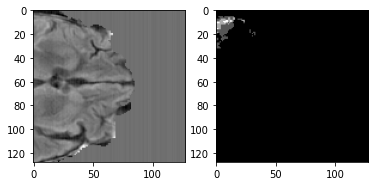

In [10]:
img_sample = img[1,0,:,:,65].detach().cpu()
target_sample = target[1,:,:,65]
plt.subplot(1,2,1)
plt.imshow(img_sample,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(target_sample,cmap='gray')

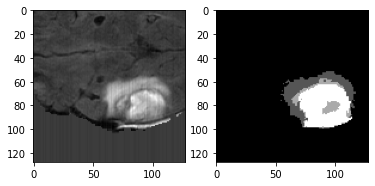

In [11]:
img_sample = img[0,0,:,:,65].detach().cpu()
target_sample = target[0,:,:,65]
plt.subplot(1,2,1)
plt.imshow(img_sample,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(target_sample,cmap='gray')

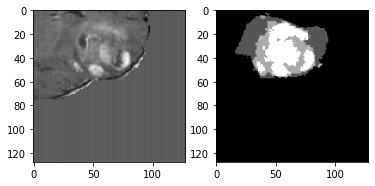

In [26]:
img_sample = img[1,2,:,:,65].detach().cpu()
target_sample = target[1,:,:,65]
plt.subplot(1,2,1)
plt.imshow(img_sample,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(target_sample,cmap='gray')

3D Unet Model

In [6]:
import torch.nn.functional as F
import torch.nn as nn

In [7]:
def initial_layer(in_dim, out_dim_pre, out_dim):
    return nn.Sequential(nn.Conv3d(in_dim, out_dim_pre, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm3d(out_dim_pre), nn.ReLU(inplace=True),
                        nn.Conv3d(out_dim_pre, out_dim, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm3d(out_dim), nn.ReLU(inplace=True))
                         
def conv_block_layer_en(in_dim, out_dim):
    return nn.Sequential(nn.Conv3d(in_dim, in_dim, kernel_size=3, stride=1, padding=1), 
                         nn.BatchNorm3d(in_dim), nn.ReLU(inplace=True),
                        nn.Conv3d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm3d(out_dim), nn.ReLU(inplace=True))

def max_pool_3d():
    return nn.MaxPool3d(kernel_size=2, stride=2, padding=0)

def conv_trans_block_3d(in_dim, out_dim):
    return nn.Sequential(
        nn.ConvTranspose3d(in_dim, out_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm3d(out_dim),
        nn.ReLU(inplace=True))
    


In [8]:
class Unet3D(nn.Module):
    def __init__(self, in_dim = 4, out_dim = 4, num_filters = 64):
        super(Unet3D, self).__init__()
        self.in_dim = in_dim
        self.num_filters = num_filters
        self.out_dim = out_dim
        
        self.conv1 = initial_layer(self.in_dim, 32, self.num_filters)
        self.pool1 = max_pool_3d()
        
        self.conv2 = conv_block_layer_en(self.num_filters, self.num_filters*2)
        self.pool2 = max_pool_3d()
        
        self.conv3 = conv_block_layer_en(self.num_filters*2, self.num_filters*4)
        self.pool3 = max_pool_3d()
        
        
              
        self.bridge = conv_block_layer_en(self.num_filters*4 , self.num_filters*8)
        
        
        self.upconv2 = conv_trans_block_3d(self.num_filters*8, self.num_filters*8)#512
        self.dconv3= conv_block_layer_en(self.num_filters* 12, self.num_filters*4)#512 + 256 | 256
        
        self.upconv3 = conv_trans_block_3d(self.num_filters*4, self.num_filters*4)#256
        self.dconv2 = conv_block_layer_en(self.num_filters* 6, self.num_filters*2)#256 + 128 | 128
        
        self.upconv4 = conv_trans_block_3d(self.num_filters*2, self.num_filters*2)#128
        self.dconv1 = conv_block_layer_en(self.num_filters*3, self.num_filters*1)#128 + 64 | 64
        
        self.final_conv = nn.Sequential(nn.Conv3d(self.num_filters, self.out_dim, kernel_size=3, padding=1))
                                        

    def forward(self,x):

        conv1 = self.conv1(x)
        pool1 = self.pool1(conv1)
        conv2 = self.conv2(pool1)
        pool2 = self.pool2(conv2)
        conv3 = self.conv3(pool2)
        pool3 = self.pool3(conv3)
        bridge = self.bridge(pool3)
                                        
        
       
        trans_2 = self.upconv2(bridge)
        concat_2 = torch.cat([trans_2, conv3], dim=1)
        dconv3 = self.dconv3(concat_2)
        
        trans_3 = self.upconv3(dconv3)
        concat_3 = torch.cat([trans_3, conv2], dim=1)
        dconv2 = self.dconv2(concat_3)
        
        trans_4 = self.upconv4(dconv2)
        concat_2 = torch.cat([trans_4, conv1], dim=1)
        dconv1 = self.dconv1(concat_2)
        
        
        x = self.final_conv(dconv1)
        x = F.softmax(x, dim=1)
        return x
        
        
        
                
        

In [120]:
# class Unet3D(nn.Module):
#     def __init__(self, in_dim = 4, out_dim = 4, num_filters = 64):
#         super(Unet3D, self).__init__()
#         self.in_dim = in_dim
#         self.num_filters = num_filters
#         self.out_dim = out_dim
        
#         self.conv1 = initial_layer(self.in_dim, 32, self.num_filters)
#         self.pool1 = max_pool_3d()
        
#         self.conv2 = conv_block_layer_en(self.num_filters, self.num_filters*2)
#         self.pool2 = max_pool_3d()
        
#         self.conv3 = conv_block_layer_en(self.num_filters*2, self.num_filters*4)
#         self.pool3 = max_pool_3d()
        
#         self.conv4 = conv_block_layer_en(self.num_filters*4, self.num_filters*8)
#         self.pool4 = max_pool_3d()
        
              
#         self.bridge = conv_block_layer_en(self.num_filters*8 , self.num_filters*16)
        
        
#         self.upconv1 = conv_trans_block_3d(self.num_filters*16, self.num_filters*16)#1024
#         self.dconv4 = conv_block_layer_en(self.num_filters* 24, self.num_filters*8)#1024 + 512 | 512
        
#         self.upconv2 = conv_trans_block_3d(self.num_filters*8, self.num_filters*8)#512
#         self.dconv3= conv_block_layer_en(self.num_filters* 12, self.num_filters*4)#512 + 256 | 256
        
#         self.upconv3 = conv_trans_block_3d(self.num_filters*4, self.num_filters*4)#256
#         self.dconv2 = conv_block_layer_en(self.num_filters* 6, self.num_filters*2)#256 + 128 | 128
        
#         self.upconv4 = conv_trans_block_3d(self.num_filters*2, self.num_filters*2)#128
#         self.dconv1 = conv_block_layer_en(self.num_filters*3, self.num_filters*1)#128 + 64 | 64
        
#         self.final_conv = nn.Sequential(nn.Conv3d(self.num_filters, self.out_dim, kernel_size=3, padding=1))
                                        

#     def forward(self,x):
#         import pdb
#         pdb.set_trace()
#         conv1 = self.conv1(x)
#         pool1 = self.pool1(conv1)
#         conv2 = self.conv2(pool1)
#         pool2 = self.pool2(conv2)
#         conv3 = self.conv3(pool2)
#         pool3 = self.pool3(conv3)
#         conv4 = self.conv4(pool3)
#         pool4 = self.pool4(conv4)
#         bridge = self.bridge(pool4)
                                        
#         trans_1 = self.upconv1(bridge)
#         concat_1 = torch.cat([trans_1, conv4], dim=1)
#         dconv4 = self.dconv4(concat_1)
       
#         trans_2 = self.upconv2(dconv4)
#         concat_2 = torch.cat([trans_2, conv3], dim=1)
#         dconv3 = self.dconv3(concat_2)
        
#         trans_3 = self.upconv3(dconv3)
#         concat_3 = torch.cat([trans_3, conv2], dim=1)
#         dconv2 = self.dconv2(concat_3)
        
#         trans_4 = self.upconv4(dconv2)
#         concat_2 = torch.cat([trans_4, conv1], dim=1)
#         dconv1 = self.dconv1(concat_2)
        
        
#         x = self.final_conv(dconv1)
#         return x
        
        
        
                
        

In [21]:
model = Unet3D(4,4,64).cuda()

RuntimeError: [enforce fail at alloc_cpu.cpp:73] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 14155776 bytes. Error code 12 (Cannot allocate memory)

In [10]:
from torchsummary import summary

In [18]:

summary(model,(4,64,64,64))

RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 31.75 GiB total capacity; 19.89 GiB already allocated; 10.52 GiB free; 20.00 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [12]:
def Dice(output, target, eps=1e-5):
    target = target.float()
    num = 2 * (output * target).sum()
    den = output.sum() + target.sum() + eps
    return 1.0 - num/den

def softmax_dice(output, target):
    '''
    The dice loss for using softmax activation function
    :param output: (b, num_class, d, h, w)
    :param target: (b, d, h, w)
    :return: softmax dice loss
    '''
    target[target == 4] = 3 
    loss0 = Dice(output[:, 0, ...], (target == 0).float())
    loss1 = Dice(output[:, 1, ...], (target == 1).float())
    loss2 = Dice(output[:, 2, ...], (target == 2).float())
    loss3 = Dice(output[:, 3, ...], (target == 3).float())

    return loss1 + loss2 + loss3 + loss0, 1-loss1.data, 1-loss2.data, 1-loss3.data

In [13]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
import time 

In [15]:
def train(model, data_loader, optimizer, res_every):
    start_time = time.time()
    torch.cuda.empty_cache()
    model.train()
    for i, data in enumerate(data_loader):
        x, target = data
        x = x.cuda()
        target = target.cuda()
        
        output = model(x)
        
        loss, loss1, loss2, loss3 = softmax_dice(output, target)
        opt.zero_grad()
        loss.backward()
        optimizer.step()
        if i%res_every==0:
            print(f"Overall Loss: {loss.item()} | L1 Dice : {loss1.item()} | L2 Dice : {loss2.item()} | L3 Dice : {loss3.item()}")
        
    end_time = time.time()
    e_time = end_time - start_time
    e_time /= 60
    print(f"Time {e_time}")

In [16]:
nEpochs = 5
res_every = 20

In [17]:
for epoch in range(nEpochs):
    train(model, train_loader, opt,res_every)


RuntimeError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 31.75 GiB total capacity; 19.49 GiB already allocated; 10.90 GiB free; 19.62 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [58]:
x = torch.rand(2,4,128,128,128)

In [40]:
x.size()

torch.Size([2, 4, 128, 128, 128])

In [67]:
import torch.nn.functional as F

In [68]:
y = F.softmax(x, dim=1)

In [69]:
y[0:1,:,1:2,1:2,1:2]

tensor([[[[[0.1607]]],


         [[[0.3343]]],


         [[[0.1631]]],


         [[[0.3419]]]]])

In [103]:
y.sum(axis=1)

tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1

In [80]:
r = torch.randint(low=0, high=4, size=(10,10))

In [81]:
r.max()

tensor(3)

In [84]:
r

tensor([[3, 1, 2, 0, 3, 3, 1, 3, 0, 3],
        [0, 2, 3, 3, 2, 3, 2, 2, 3, 1],
        [3, 0, 3, 3, 3, 1, 0, 1, 3, 2],
        [0, 2, 0, 3, 0, 0, 3, 1, 3, 3],
        [2, 0, 0, 2, 1, 0, 3, 2, 0, 1],
        [1, 3, 3, 1, 3, 1, 1, 2, 1, 2],
        [2, 2, 0, 1, 3, 1, 3, 0, 1, 0],
        [2, 2, 2, 3, 0, 3, 0, 3, 1, 2],
        [2, 0, 0, 1, 2, 2, 1, 1, 1, 3],
        [2, 1, 3, 1, 0, 0, 1, 3, 1, 1]])

In [89]:
(r==3).float()

tensor([[1., 0., 0., 0., 1., 1., 0., 1., 0., 1.],
        [0., 0., 1., 1., 0., 1., 0., 0., 1., 0.],
        [1., 0., 1., 1., 1., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 1., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]])